<a href="https://colab.research.google.com/github/riesacassano/fMRI_piano/blob/master/ryc_101521_WvA_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script implements the within vs across measure, first with simulated data and then with example real data. The WvA calculation is adapted from Jamal's script [hmm_K_sweep_paper_no_srm.py](https://github.com/jamalw/music_event_structures_bucket/blob/master/hmm_K_sweep_paper_no_srm.py). Data simulation is borrowed from [BrainIAK tutorial 12](https://brainiak.org/tutorials/12-hmm/). 

In [1]:
!pip install brainiak

     |████████████████████████████████| 6.8 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 6.2 MB 20.5 MB/s 
     |████████████████████████████████| 2.8 MB 32.5 MB/s 
     |████████████████████████████████| 2.4 MB 29.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 30.1 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for brainiak: filename=brainiak-0.11-cp37-cp37m-linux_x86_64.whl size=1104058 sha256=756d84174f7f166160dad07654fe1066a3a8204a31718309fcd592992e68598d
  Stored in directory: /root/.cache/pip/wheels/9b/a1/5f/b7ac0f991e9f859ccf0f58e531343f763da84c218016adee79
  Created wheel for mpi4py:

In [2]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from brainiak.eventseg.event import EventSegment
import matplotlib.pyplot as plt

Generate simulated data with known number of events.

In [3]:
def generate_event_labels(T, K, length_std):
    event_labels = np.zeros(T, dtype=int)
    start_TR = 0
    for e in range(K - 1):
        length = round(
            ((T - start_TR) / (K - e)) * (1 + length_std * np.random.randn()))
        length = min(max(length, 1), T - start_TR - (K - e))
        event_labels[start_TR:(start_TR + length)] = e
        start_TR = start_TR + length
    event_labels[start_TR:] = K - 1

    return event_labels


def generate_data(V, T, event_labels, event_means, noise_std):
    simul_data = np.empty((V, T))
    for t in range(T):
        simul_data[:, t] = stats.multivariate_normal.rvs(
            event_means[:, event_labels[t]], cov=noise_std, size=1)

    simul_data = stats.zscore(simul_data, axis=1, ddof=1)
    return simul_data

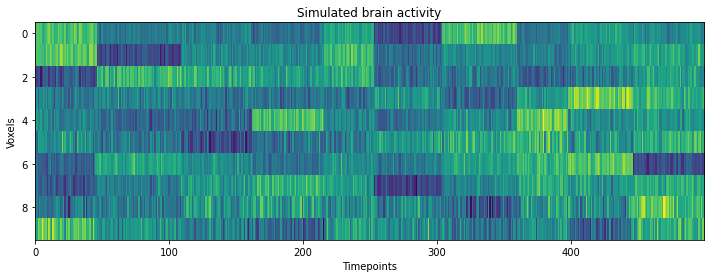

In [4]:
# Parameters for creating small simulated datasets
V = 10 # number of voxels
K = 10 # number of events
T = 500 # Time points

# Generate the first dataset
np.random.seed(1)
event_means = np.random.randn(V, K)
event_labels = generate_event_labels(T, K, 0.2)
D = generate_data(V, T, event_labels, event_means, 1/4)

# Check the data
f, ax = plt.subplots(1,1, figsize=(12, 4))
ax.imshow(D, interpolation='nearest', cmap='viridis', aspect='auto')
ax.set_ylabel('Voxels')
ax.set_title('Simulated brain activity')
ax.set_xlabel('Timepoints');

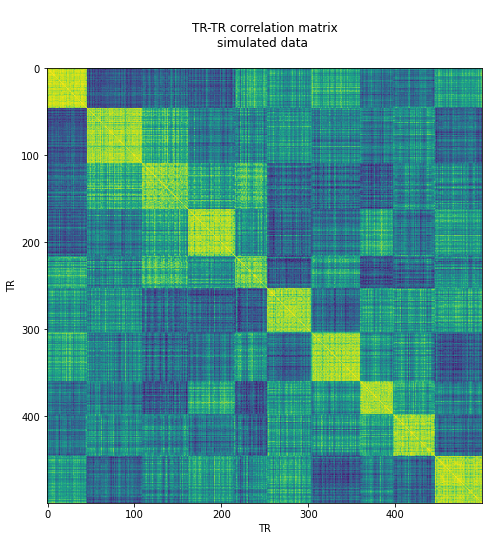

In [5]:
# Show the timepoint by timepoint correlation matrix
f, ax = plt.subplots(1,1, figsize = (10,8))
ax.imshow(np.corrcoef(D.T), cmap='viridis')
title_text = '''
TR-TR correlation matrix
simulated data 
'''
ax.set_title(title_text)
ax.set_xlabel('TR')
ax.set_ylabel('TR');

In [6]:
print(D.shape)

(10, 500)


In [7]:
# Find the events in this dataset using ground truth K
ev = EventSegment(K)
ev.fit(D.T)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10, n_iter=500, split_merge=False,
             split_merge_proposals=1,
             step_var=<function EventSegment._default_var_schedule at 0x7f37ea59d5f0>)

In [8]:
print(len(ev.segments_[0]))
print(ev.segments_[0][0])

500
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


For each time point, `segments_` indicates the probability that that time point is in each event. For time point 0, the model determines p = 1 that this time point is in the first event.

Taking the argmax of `segments_` essentially gives you the model's predictions of which event each time point is in.

In [9]:
events = np.argmax(ev.segments_[0],axis=1)
print(events)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

In [12]:
max_event_length = stats.mode(events)[1][0]
print(max_event_length)

63


The longest event is 63 TRs.

In [20]:
unique, counts = np.unique(events,return_counts=True)
print(counts)

[46 63 53 54 37 51 56 38 48 54]


In [10]:
# Compute timepoint by timepoint correlation matrix 
cc = np.corrcoef(D.T)
# Should be a time by time correlation matrix
print(cc.shape)

(500, 500)


In [13]:
# Create a mask to only look at values up to max_event_length
local_mask = np.zeros(cc.shape, dtype=bool)
for k in range(1,max_event_length):
  local_mask[np.diag(np.ones(cc.shape[0]-k, dtype=bool), k)] = True

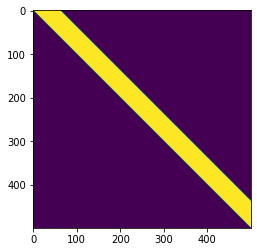

In [14]:
# Convert the mask to 0s and 1s to visualize
local_mask.astype('int')
plt.imshow(local_mask)
# Convert it back to bool for next steps
local_mask.astype('bool');

In [15]:
# Compute within vs across boundary correlations
same_event = events[:,np.newaxis] == events
print(same_event)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


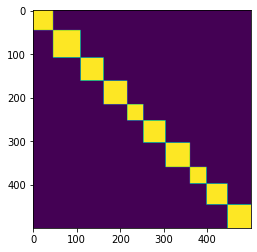

In [16]:
same_event.astype('int')
plt.imshow(same_event)
same_event.astype('bool');

In [17]:
print(same_event*local_mask)

[[False  True  True ... False False False]
 [False False  True ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False  True  True]
 [False False False ... False False  True]
 [False False False ... False False False]]


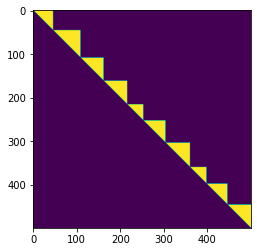

In [18]:
jasmine = same_event*local_mask
jasmine.astype('int')
plt.imshow(jasmine)
jasmine.astype('bool');

In [21]:
print(cc[same_event*local_mask])
print(cc[same_event*local_mask].shape)
print(np.sum(same_event*local_mask))

[0.64231585 0.92893451 0.89258341 ... 0.73921026 0.691506   0.88841593]
(12540,)
12540


In [25]:
print(cc[(~same_event)*local_mask].shape)

(16507,)


In [31]:
within = cc[same_event*local_mask].mean()
print(within)
across = cc[(~same_event)*local_mask].mean()
print(across)

within_across = within - across
print(within_across)
#wVa_results[i,j,b] = within_across

0.698166082391958
-0.07346147670780222
0.7716275590997602


Perform a mini-k-sweep on the simulated data.

In [26]:
k_test = [2,3,5,8,10,12,15,18,20]
print(len(k_test))

9
